<a href="https://colab.research.google.com/github/drstannwoji2019/AITools_LRL_NLP/blob/main/SC_CDD_EBS2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install deps & import
!pip -q install wordcloud==1.9.3 nltk==3.9.1

import re
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# NLTK resources
nltk.download("stopwords", quiet=True)

# Use a guaranteed TTF font on Colab
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

# Matplotlib defaults (no explicit colors per your constraints)
plt.rcParams.update({"figure.figsize": (10, 6), "axes.grid": False})


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 10.7 MB/s eta 0:00:00


In [7]:
# Load data
# @title Upload the cleaned abstracts file (TXT)
from google.colab import files

print("Upload your TXT (e.g., Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt)")
uploaded = files.upload("content/sample_data/Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt")  # choose your file
fname = next(iter(uploaded))
text_data = io.StringIO(uploaded[fname].decode("utf-8", errors="ignore")).read()


Upload your TXT (e.g., Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt)


Saving Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt to content/sample_data/Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt/Abstract_SupplyChain_CounterfeitDrugDetection_Cleaned.txt


In [8]:
# @title Preprocess & remove stopwords
# Split into abstracts (paragraphs separated by blank lines OR newlines)
abstracts = [seg.strip() for seg in re.split(r"\n\s*\n|\r?\n", text_data) if seg.strip()]

# Tokenizer
def tokenize(s: str):
    s = re.sub(r"http[s]?://\S+|www\.\S+", " ", s)   # remove URLs
    s = re.sub(r"[\d_]+", " ", s)                    # remove digits/underscores
    s = s.lower()
    return re.findall(r"[a-z][a-z\-]{2,}", s)        # alphabetic/hyphenated words 3+ chars

# English stopwords (NLTK)
sw = set(stopwords.words("english"))

# Optional domain-neutral additions (keep minimal; add more if needed)
extra_sw = {"use","using","used","study","paper","system","approach","method","methods",
            "including","includes","include","results","data","model","models","analysis"}
sw |= extra_sw

# Flatten tokens
tokens = [t for abs_ in abstracts for t in tokenize(abs_) if t not in sw]

print(f"Docs: {len(abstracts)} | Tokens (after filtering): {len(tokens)}")


Docs: 418 | Tokens (after filtering): 17745


,term,count
0,blockchain,240
1,counterfeit,222
2,drugs,194
3,drug,185
4,supply,177
5,pharmaceutical,166
6,chain,162
7,technology,152
8,health,144
9,medicines,138


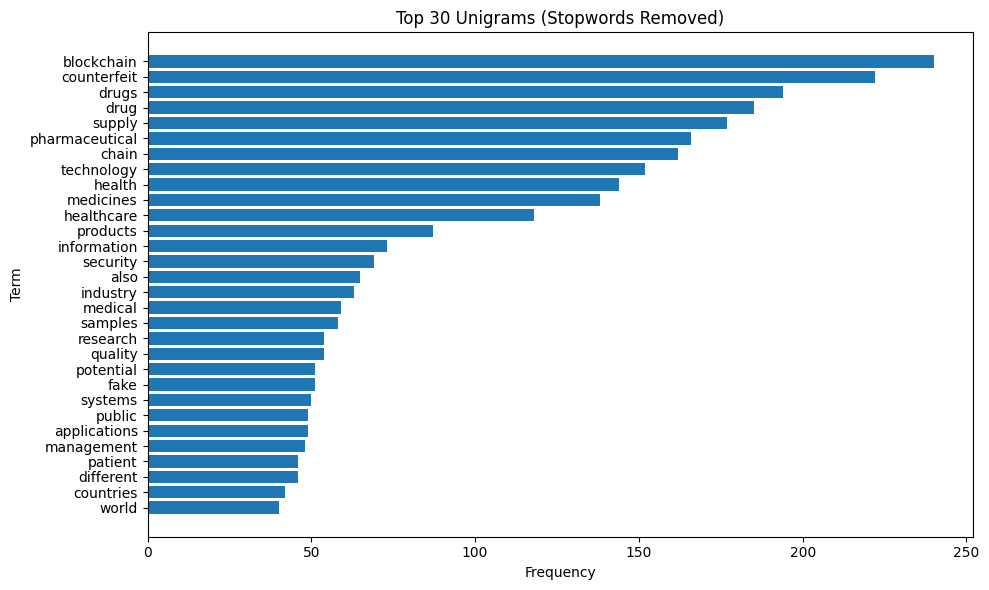

In [9]:
# @title Unigram frequencies
unigram_counts = Counter(tokens)
uni_top = pd.DataFrame(unigram_counts.most_common(30), columns=["term","count"])
display(uni_top)

# Bar chart
plt.figure()
plt.barh(uni_top["term"][::-1], uni_top["count"][::-1])
plt.title("Top 30 Unigrams (Stopwords Removed)")
plt.xlabel("Frequency"); plt.ylabel("Term")
plt.tight_layout(); plt.show()


,ngram,count
0,supply chain,143
1,blockchain technology,91
2,counterfeit drugs,83
3,counterfeit medicines,35
4,public health,34
5,pharmaceutical industry,34
6,pharmaceutical supply,33
7,counterfeit drug,26
8,chain management,23
9,drug supply,22


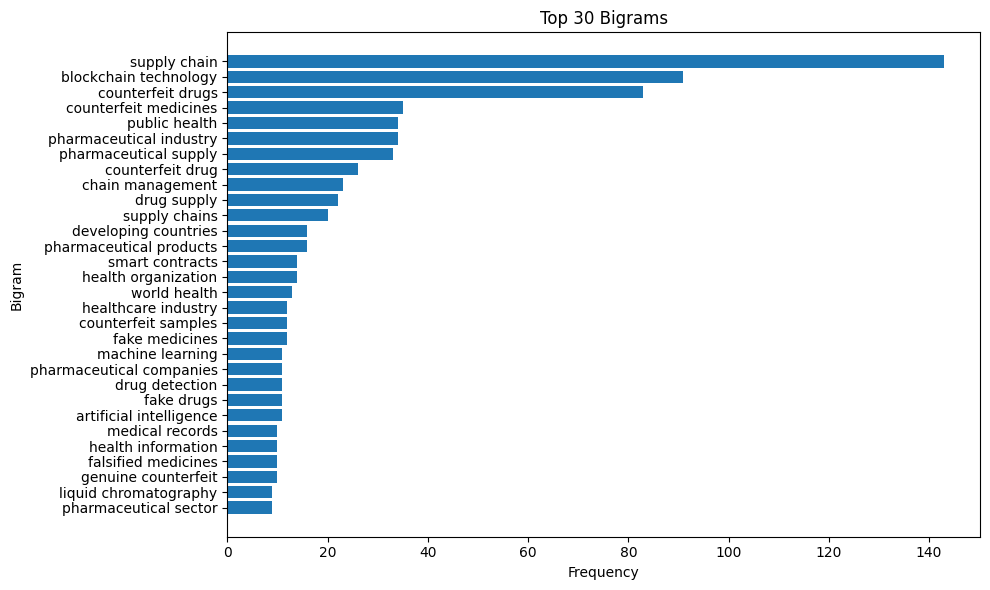

,ngram,count
0,supply chain management,23
1,pharmaceutical supply chain,20
2,drug supply chain,18
3,world health organization,13
4,pharmaceutical supply chains,11
5,counterfeit drug detection,9
6,genuine counterfeit samples,8
7,healthcare supply chain,6
8,threat public health,6
9,internet things iot,6


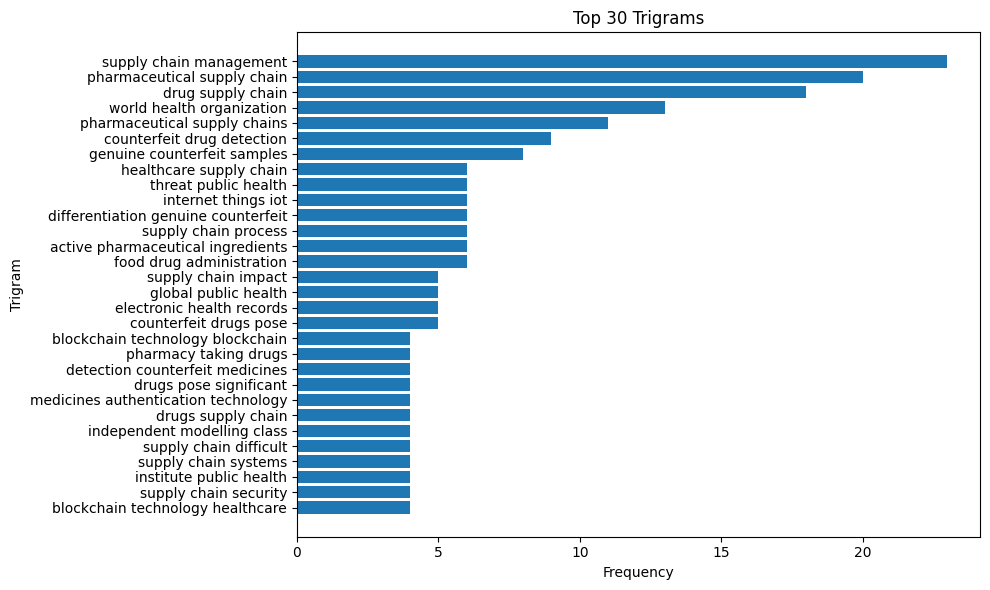

In [10]:
# @title Helper to make n-grams with CountVectorizer
def top_ngrams(docs, ngram_range=(2,2), top_n=30, stop_set=None):
    cv = CountVectorizer(ngram_range=ngram_range,
                         token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z\-]{2,}\b",
                         stop_words=list(stop_set) if stop_set else None)
    X = cv.fit_transform(docs)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    idx = freqs.argsort()[::-1][:top_n]
    return pd.DataFrame({"ngram": terms[idx], "count": freqs[idx]})

# Recompose docs as cleaned strings (so CountVectorizer can apply stopwords consistently)
clean_docs = []
for abs_ in abstracts:
    toks = [t for t in tokenize(abs_) if t not in sw]
    clean_docs.append(" ".join(toks))

bi_top = top_ngrams(clean_docs, ngram_range=(2,2), top_n=30, stop_set=sw)
tri_top = top_ngrams(clean_docs, ngram_range=(3,3), top_n=30, stop_set=sw)

display(bi_top.head(30))
plt.figure()
plt.barh(bi_top["ngram"][::-1], bi_top["count"][::-1])
plt.title("Top 30 Bigrams")
plt.xlabel("Frequency"); plt.ylabel("Bigram")
plt.tight_layout(); plt.show()

display(tri_top.head(30))
plt.figure()
plt.barh(tri_top["ngram"][::-1], tri_top["count"][::-1])
plt.title("Top 30 Trigrams")
plt.xlabel("Frequency"); plt.ylabel("Trigram")
plt.tight_layout(); plt.show()


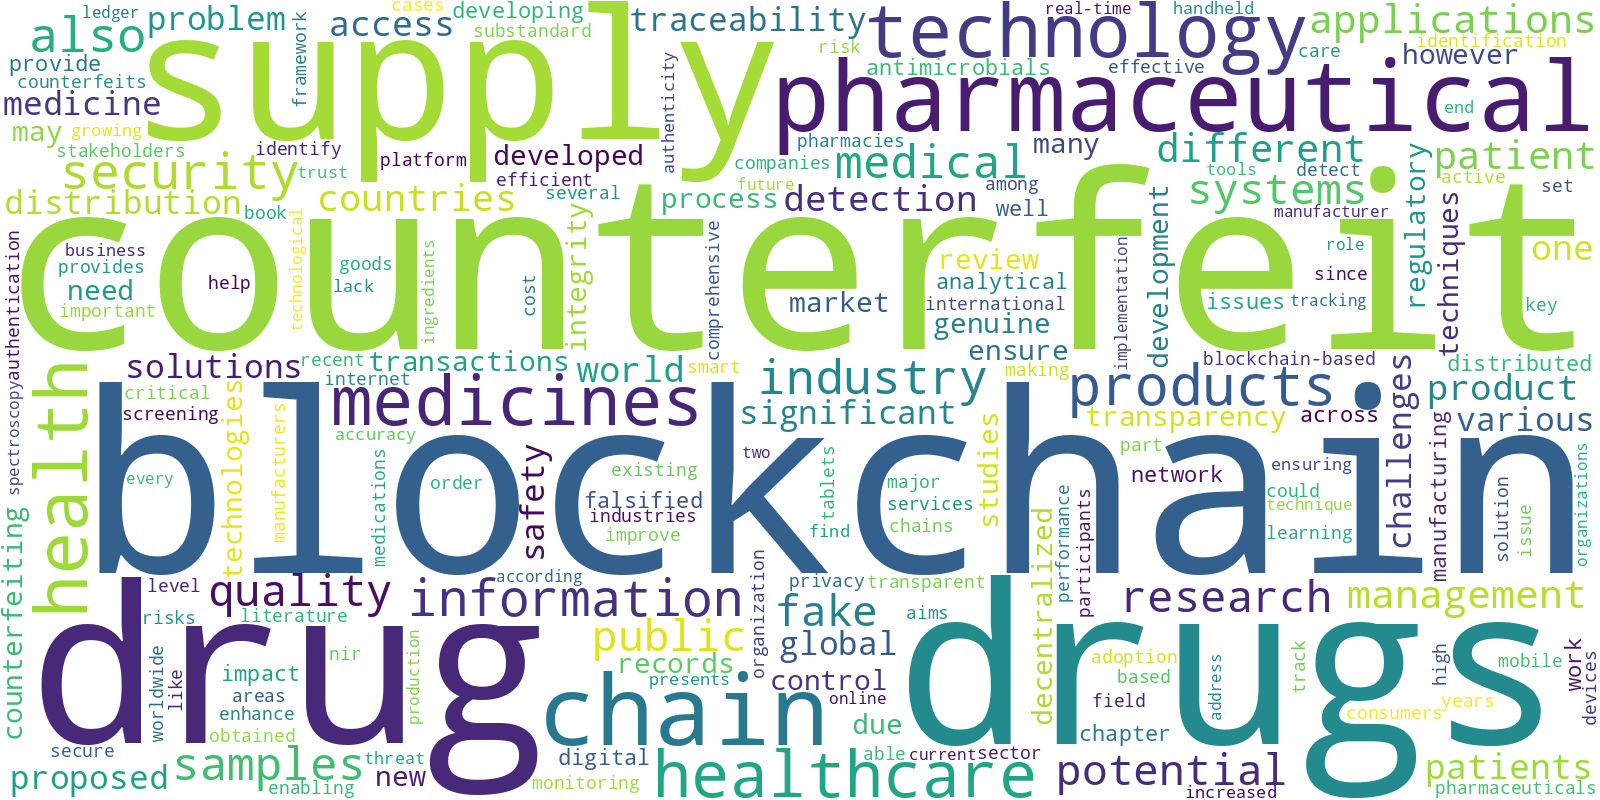

In [13]:
# @title Word clouds (with DejaVuSans.ttf)

# Unigram cloud from frequency dict
uni_freqs = dict(unigram_counts.most_common(500))
wc_uni = WordCloud(width=1600, height=800, background_color="white",
                   collocations=False)
wc_uni = wc_uni.generate_from_frequencies(uni_freqs)
wc_uni.to_file("wordcloud_unigrams.png")

# Bigram/trigram clouds: build frequency dicts from the tables
bi_freqs = dict(zip(bi_top["ngram"], bi_top["count"]))
wc_bi = WordCloud(width=1600, height=800, background_color="white",
                  collocations=False)
wc_bi = wc_bi.generate_from_frequencies(bi_freqs)
wc_bi.to_file("wordcloud_bigrams.png")

tri_freqs = dict(zip(tri_top["ngram"], tri_top["count"]))
wc_tri = WordCloud(width=1600, height=800, background_color="white",
                   collocations=False)
wc_tri = wc_tri.generate_from_frequencies(tri_freqs)
wc_tri.to_file("wordcloud_trigrams.png")

from IPython.display import Image, display
display(Image("wordcloud_unigrams.png"))

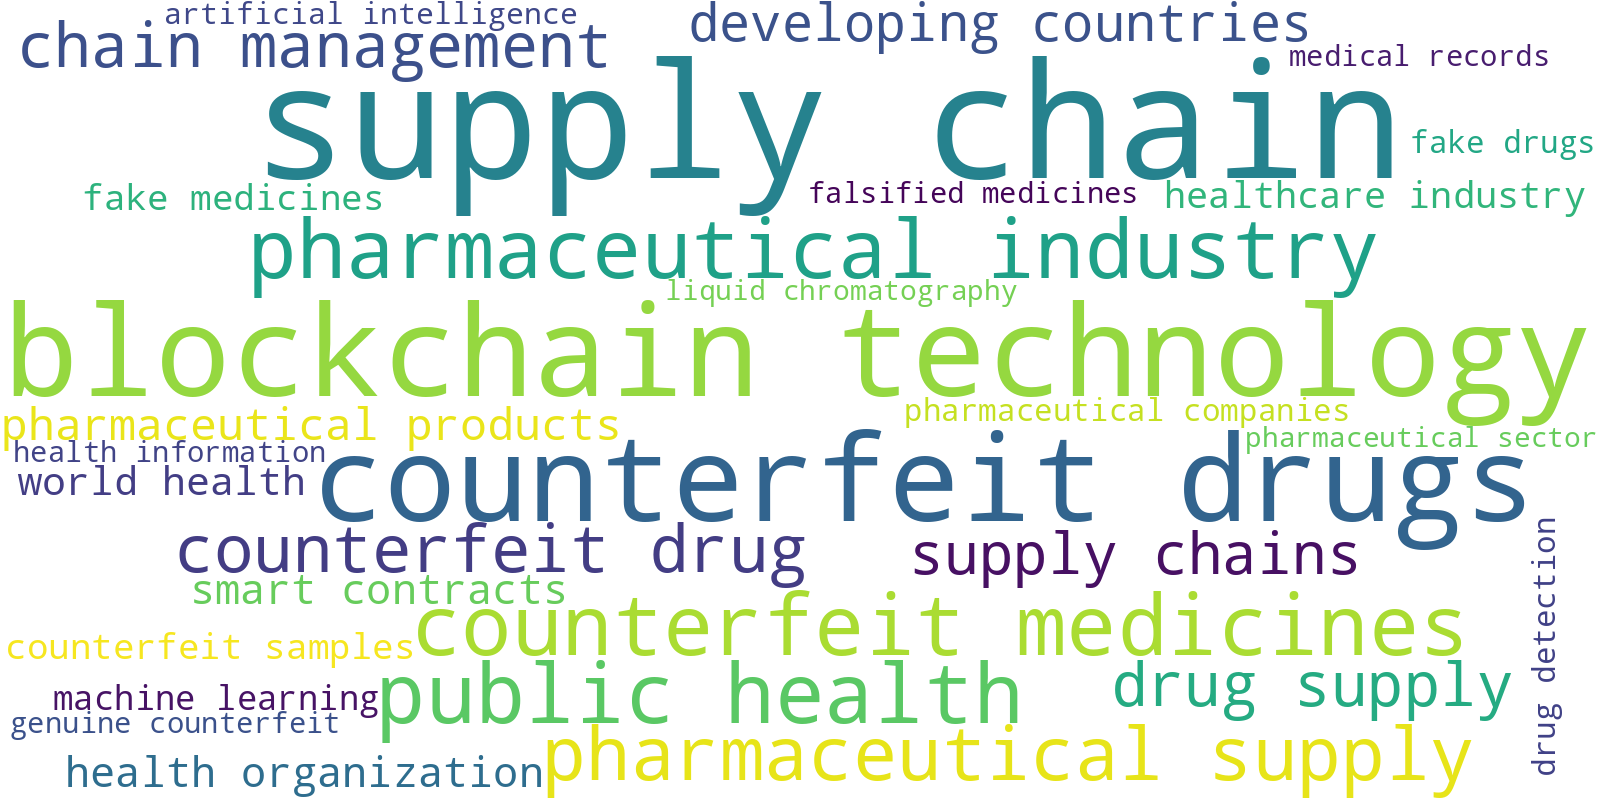

In [14]:

display(Image("wordcloud_bigrams.png"))

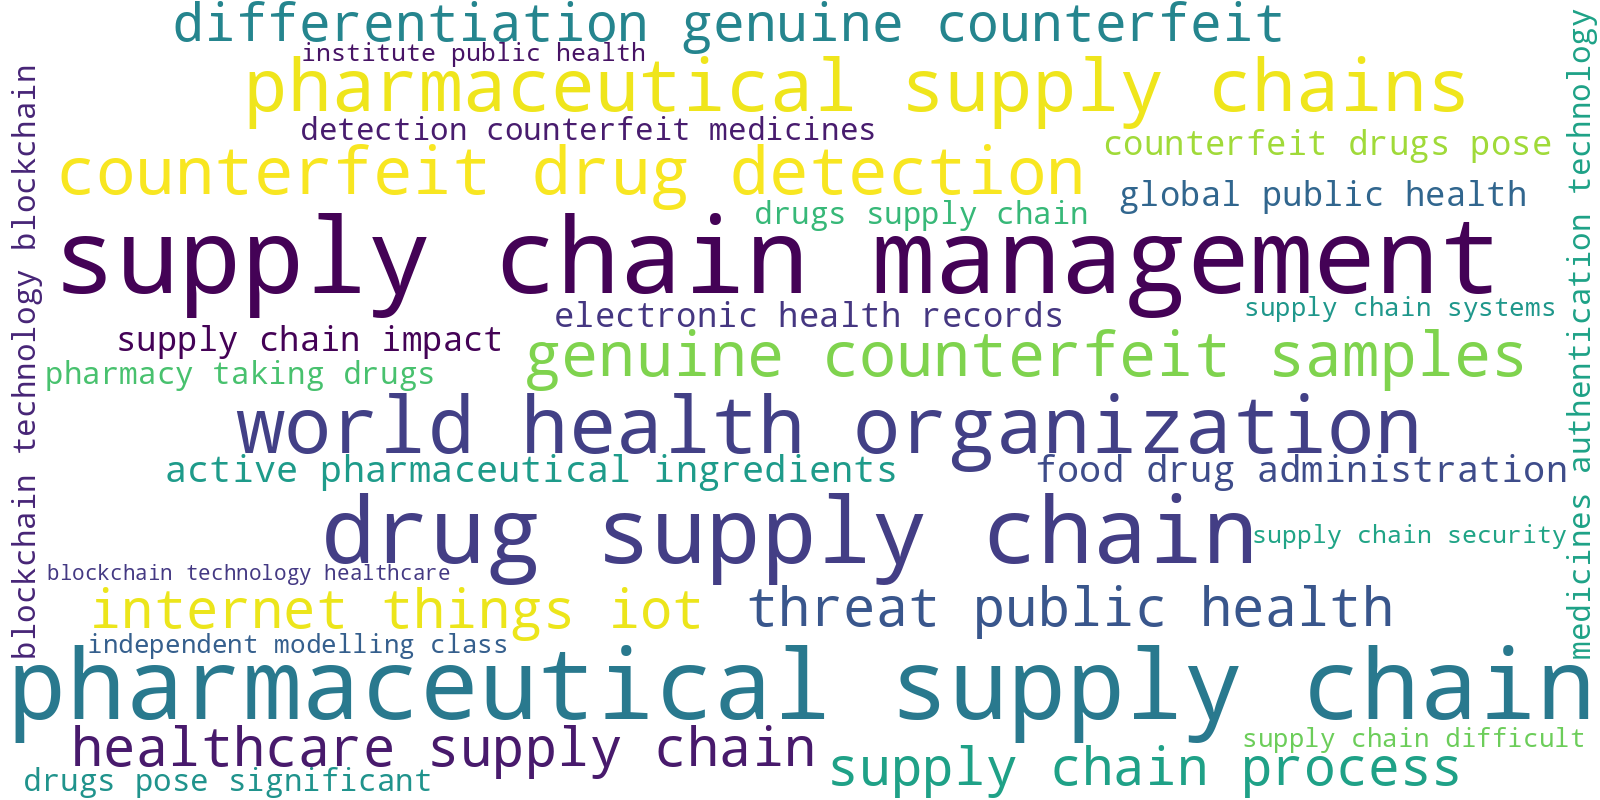

In [15]:

display(Image("wordcloud_trigrams.png"))

In [16]:
# @title Topic Modeling: NMF (on TF-IDF) and LDA (on term-frequency)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Build TF-IDF (uni+bi-grams) on cleaned docs
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2), stop_words=list(sw))
X_tfidf = tfidf.fit_transform(clean_docs)
terms_tfidf = tfidf.get_feature_names_out()

# Helper: show top words
def top_words_from_components(components, vocab, top_n=12):
    out = []
    for k, row in enumerate(components):
        idx = row.argsort()[::-1][:top_n]
        out.append({"topic": k, "top_words": ", ".join(vocab[idx])})
    return pd.DataFrame(out)

# --- NMF on TF-IDF ---
nmf_k = 6  # tweak if you want
nmf = NMF(n_components=nmf_k, init="nndsvd", random_state=42, max_iter=400)
W_nmf = nmf.fit_transform(X_tfidf)
H_nmf = nmf.components_
nmf_topics = top_words_from_components(H_nmf, terms_tfidf, top_n=12)

print("NMF Topics (top words):")
display(nmf_topics)

# --- LDA on term-frequency (unigrams only) ---
cv = CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1,1), stop_words=list(sw))
X_tf = cv.fit_transform(clean_docs)
terms_tf = cv.get_feature_names_out()

lda_k = 6
lda = LatentDirichletAllocation(n_components=lda_k, random_state=42, learning_method="batch", max_iter=30)
lda_W = lda.fit_transform(X_tf)
lda_H = lda.components_

# Convert LDA components to top words
lda_topics = []
for k, row in enumerate(lda_H):
    idx = row.argsort()[::-1][:12]
    lda_topics.append({"topic": k, "top_words": ", ".join(terms_tf[idx])})
lda_topics = pd.DataFrame(lda_topics)

print("LDA Topics (top words):")
display(lda_topics)

# Per-document dominant topic assignments
nmf_dom = W_nmf.argmax(axis=1)
lda_dom = lda_W.argmax(axis=1)

topic_assignments = pd.DataFrame({
    "doc_id": np.arange(len(clean_docs)),
    "nmf_topic": nmf_dom,
    "lda_topic": lda_dom
})

display(topic_assignments.head(10))


NMF Topics (top words):


,topic,top_words
0,0,"chain, supply, supply chain, blockchain, pharm..."
1,1,"drugs, counterfeit, medicines, counterfeit dru..."
2,2,"blockchain, healthcare, technology, blockchain..."
3,3,"antimicrobials, identification, site, part, an..."
4,4,"pharmacies, secret, secret shopper, shopper, c..."
5,5,"samples, different, nir, counterfeit samples, ..."


LDA Topics (top words):


,topic,top_words
0,0,"blockchain, healthcare, technology, security, ..."
1,1,"health, chain, imaging, pharmacies, devices, s..."
2,2,"blockchain, supply, chain, pharmaceutical, cou..."
3,3,"drugs, counterfeit, drug, medicines, informati..."
4,4,"antimicrobials, drugs, drug, samples, medicine..."
5,5,"counterfeit, medicines, samples, pharmaceutica..."


,doc_id,nmf_topic,lda_topic
0,0,2,2
1,1,0,2
2,2,0,2
3,3,0,3
4,4,1,0
5,5,2,2
6,6,0,2
7,7,1,2
8,8,1,2
9,9,1,2


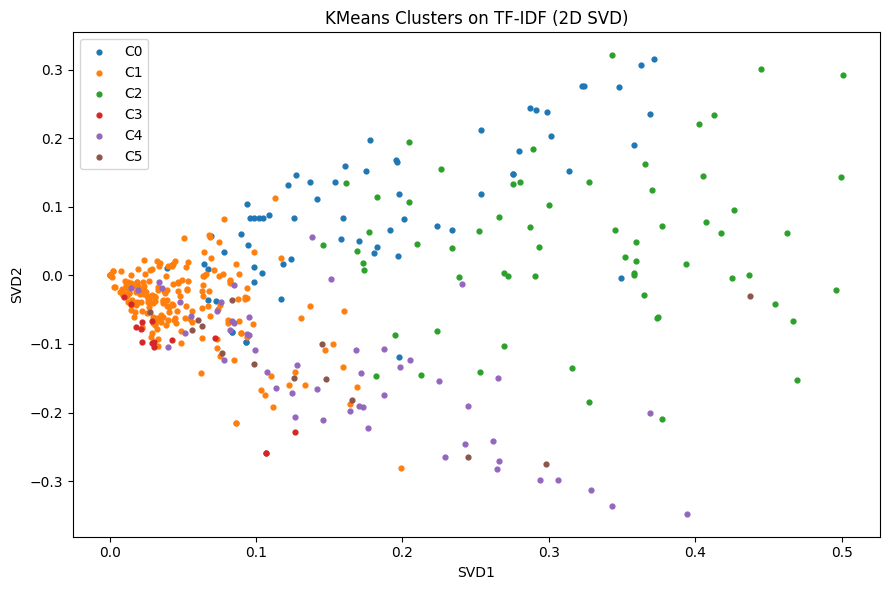

,doc_id,kmeans_cluster,nmf_topic,lda_topic
0,0,2,2,2
1,1,2,0,2
2,2,2,0,2
3,3,2,0,3
4,4,2,1,0
5,5,2,2,2
6,6,2,0,2
7,7,2,1,2
8,8,2,1,2
9,9,4,1,2


In [17]:
# @title Clustering with KMeans on TF-IDF + 2D SVD scatter
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

k = 6  # number of clusters
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = km.fit_predict(X_tfidf)

# 2D projection of TF-IDF with SVD
svd = TruncatedSVD(n_components=2, random_state=42)
X2 = svd.fit_transform(X_tfidf)

# Scatter plot (each cluster is a color)
plt.figure(figsize=(9, 6))
for c in range(k):
    pts = X2[labels == c]
    plt.scatter(pts[:, 0], pts[:, 1], s=12, label=f"C{c}")
plt.legend()
plt.title("KMeans Clusters on TF-IDF (2D SVD)")
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.tight_layout()
plt.show()

# Combine with topic assignments for inspection
cluster_topics = pd.DataFrame({
    "doc_id": np.arange(len(clean_docs)),
    "kmeans_cluster": labels,
    "nmf_topic": nmf_dom,
    "lda_topic": lda_dom
})
display(cluster_topics.head(10))


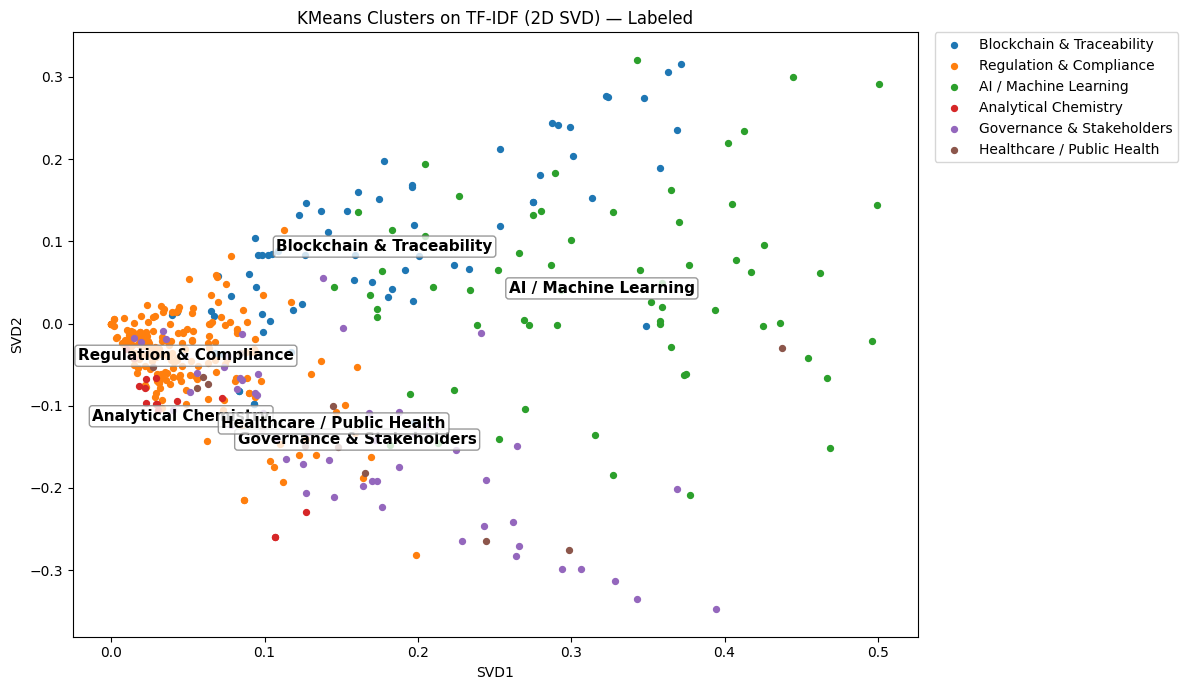

Saved figure -> kmeans_svd2_labeled.png


<Figure size 1000x600 with 0 Axes>

In [18]:
# Map cluster IDs -> human-friendly labels (tweak if your topics differ)
cluster_label_map = {
    0: "Blockchain & Traceability",
    1: "Regulation & Compliance",
    2: "AI / Machine Learning",
    3: "Analytical Chemistry",
    4: "Governance & Stakeholders",
    5: "Healthcare / Public Health",
}

import numpy as np
import matplotlib.pyplot as plt

# Colors for up to 6 clusters (same order as 0..5)
colors = ["C0","C1","C2","C3","C4","C5"]

# Compute 2D centroids in the SVD space
centroids = {}
for c in np.unique(labels):
    pts = X2[labels == c]
    centroids[c] = pts.mean(axis=0)

# Plot points
plt.figure(figsize=(12,7))
for c in np.unique(labels):
    pts = X2[labels == c]
    plt.scatter(pts[:,0], pts[:,1], s=18, label=cluster_label_map.get(c, f"Cluster {c}"), c=colors[c])

# Annotate centroids with big labels
for c, (x,y) in centroids.items():
    plt.text(x, y, cluster_label_map.get(c, f"Cluster {c}"),
             ha="center", va="center", fontsize=11, weight="bold",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8))

plt.title("KMeans Clusters on TF-IDF (2D SVD) — Labeled")
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.legend(loc="upper left", bbox_to_anchor=(1.02,1.0), borderaxespad=0.)
plt.tight_layout()
plt.show()

# Optional: save to file
plt.savefig("kmeans_svd2_labeled.png", dpi=200, bbox_inches="tight")
print("Saved figure -> kmeans_svd2_labeled.png")


In [19]:
# -------- Top Terms per Cluster (TF-IDF) --------
import numpy as np
import pandas as pd

# Safety checks
assert "X_tfidf" in globals(), "X_tfidf not found"
assert "tfidf" in globals(), "tfidf vectorizer not found"
assert "labels" in globals(), "labels not found"

feature_names = np.array(tfidf.get_feature_names_out())
k = len(np.unique(labels))
TOP_N = 15  # terms per cluster

rows = []
for c in range(k):
    mask = (labels == c)
    if mask.sum() == 0:
        continue
    # mean TF-IDF for each term within the cluster
    cluster_mean = X_tfidf[mask].mean(axis=0).A1  # dense 1D
    top_idx = cluster_mean.argsort()[::-1][:TOP_N]
    top_terms = feature_names[top_idx]
    top_scores = cluster_mean[top_idx]

    label_name = cluster_label_map.get(c, f"Cluster {c}") if "cluster_label_map" in globals() else f"Cluster {c}"
    rows.append({
        "cluster_id": c,
        "cluster_label": label_name,
        "top_terms": ", ".join(top_terms),
        "top_scores": ", ".join([f"{s:.4f}" for s in top_scores])
    })

cluster_terms_df = pd.DataFrame(rows, columns=["cluster_id","cluster_label","top_terms","top_scores"])
display(cluster_terms_df)

# Save to CSV for your thesis appendix
cluster_terms_df.to_csv("cluster_top_terms.csv", index=False)
print("Saved -> cluster_top_terms.csv")


,cluster_id,cluster_label,top_terms,top_scores
0,0,Blockchain & Traceability,"blockchain, healthcare, technology, blockchain...","0.0991, 0.0733, 0.0628, 0.0457, 0.0326, 0.0322..."
1,1,Regulation & Compliance,"antimicrobials, pharmacies, health, different,...","0.0268, 0.0176, 0.0154, 0.0142, 0.0129, 0.0128..."
2,2,AI / Machine Learning,"chain, supply, supply chain, blockchain, count...","0.1164, 0.1129, 0.1009, 0.0988, 0.0672, 0.0652..."
3,3,Analytical Chemistry,"samples, chemical, heavy metals, metals, heavy...","0.2655, 0.0701, 0.0679, 0.0679, 0.0630, 0.0597..."
4,4,Governance & Stakeholders,"counterfeit, drug, medicines, drugs, counterfe...","0.0848, 0.0841, 0.0773, 0.0620, 0.0422, 0.0310..."
5,5,Healthcare / Public Health,"drugs, ingredients, contain, active, trace, co...","0.1943, 0.1213, 0.0841, 0.0549, 0.0530, 0.0502..."


Saved -> cluster_top_terms.csv


In [20]:
# -------- Representative Documents per Cluster --------
from sklearn.metrics.pairwise import cosine_distances

assert "clean_docs" in globals(), "clean_docs (list of strings) not found"

rep_rows = []
N_PER_CLUSTER = 5  # how many exemplar docs to list

# use KMeans centers if available; else compute mean vector
if "km" in globals():
    centers = km.cluster_centers_
else:
    # fallback: mean vector per cluster
    centers = np.vstack([X_tfidf[labels==c].mean(axis=0).A1 for c in range(k)])

for c in range(k):
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        continue
    # distances to center
    dists = cosine_distances(X_tfidf[idx], centers[c].reshape(1, -1)).ravel()
    order = np.argsort(dists)[:N_PER_CLUSTER]
    chosen = idx[order]
    for rank, doc_id in enumerate(chosen, 1):
        rep_rows.append({
            "cluster_id": c,
            "cluster_label": cluster_label_map.get(c, f"Cluster {c}") if "cluster_label_map" in globals() else f"Cluster {c}",
            "rank": rank,
            "doc_id": int(doc_id),
            "excerpt": (clean_docs[doc_id][:300] + "…") if len(clean_docs[doc_id]) > 300 else clean_docs[doc_id]
        })

rep_df = pd.DataFrame(rep_rows, columns=["cluster_id","cluster_label","rank","doc_id","excerpt"])
display(rep_df)

rep_df.to_csv("cluster_representative_docs.csv", index=False)
print("Saved -> cluster_representative_docs.csv")


,cluster_id,cluster_label,rank,doc_id,excerpt
0,0,Blockchain & Traceability,1,164,blockchain new technology offers decentralized...
1,0,Blockchain & Traceability,2,179,one important discoveries creative development...
2,0,Blockchain & Traceability,3,323,predictive blockchain technology securing elec...
3,0,Blockchain & Traceability,4,140,blockchain machine learning transformative tec...
4,0,Blockchain & Traceability,5,160,telemedicine revolutionized healthcare deliver...
5,1,Regulation & Compliance,1,159,threats substandard falsified antimicrobials p...
6,1,Regulation & Compliance,2,307,near-infrared nir spectroscopy actually well-e...
7,1,Regulation & Compliance,3,178,reference laboratory federal agency medicines ...
8,1,Regulation & Compliance,4,324,exposure unknown mislabeled counterfeit pharma...
9,1,Regulation & Compliance,5,396,summarize content information obtained online ...


Saved -> cluster_representative_docs.csv
